### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempProp/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 119 ms, sys: 29.3 ms, total: 148 ms
Wall time: 170 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
%%time
after = 1
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)


CPU times: user 3.06 s, sys: 24.8 ms, total: 3.09 s
Wall time: 3.09 s


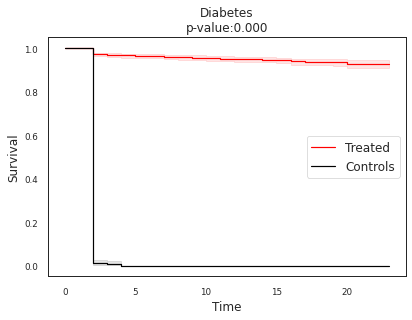

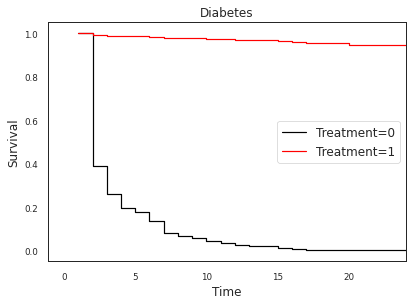

In [10]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [11]:
lrsumm

test_statistic    p  -log2(p)
Diabetes     1734.829937  0.0       inf

In [12]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  0.092           0.283        0.324    0.746
Gender               0.100           0.097        1.038    0.299
Total Cost           0.062           0.073        0.854    0.393
Tobacco use         -0.078           0.137       -0.566    0.572
Obesity              0.005           0.098        0.054    0.957
Hypertension         0.019           0.107        0.177    0.860
Hypothyroid          0.032           0.143        0.224    0.822
Disease Count        0.518           0.369        1.403    0.161
Treatment           -4.735           0.179      -26.518    0.000

### ER

In [13]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [14]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)


CPU times: user 2.98 s, sys: 6.65 ms, total: 2.99 s
Wall time: 2.99 s


In [15]:
treated[treated.PERS_ID == "2578414"]['ALLOW_IP']

Series([], Name: ALLOW_IP, dtype: float64)

In [16]:
survTr[survTr.PERS_ID == "2578414"]

Empty DataFrame
Columns: [PERS_ID, T, E, ACUTE, ACUTE2, ACUTE6, ACUTE_C, AGE_AT_MIDMONTH, ALLOW_AMT, ALLOW_ER, ALLOW_IP, CC_ADHD, CC_ALZHEIMER, CC_ALZHEIMER_PLUS, CC_AMI, CC_ANEMIA, CC_ANXIETY_DISORDER, CC_ARTHRITIS, CC_ASTHMA, CC_ATRIAL_FIB, CC_AUTISM, CC_BIPOLAR, CC_BPH, CC_BREAST_CANCER, CC_CATARACT, CC_CEREBRAL_PALSY, CC_CHRONIC_KIDNEY, CC_COLORECTAL_CANCER, CC_COPD, CC_CYSTIC_FIBROSIS, CC_DEPRESSION, CC_DEPRESSIVE_DISORDERS, CC_DEVELOP_DELAYS, CC_DIABETES, CC_DISAB_DX_CNT, CC_DX_CNT, CC_ENDOMETRIAL_CANCER, CC_EPILEPSY, CC_FIBROMYALGIA, CC_GLAUCOMA, CC_HEARING_IMPAIR, CC_HEART_FAILURE, CC_HEPATITIS_A, CC_HEPATITIS_B_ACUTE, CC_HEPATITIS_B_CHRONIC, CC_HEPATITIS_C_ACUTE, CC_HEPATITIS_C_CHRONIC, CC_HEPATITIS_C_UNSPECIFIED, CC_HEPATITIS_D, CC_HEPATITIS_E, CC_HEPATITIS_GEN, CC_HIP_FRACTURE, CC_HYPERLIPIDEMIA, CC_HYPERTENSION, CC_HYPOTHYROID, CC_INT_DISAB, CC_ISCHEMIC, CC_LEARN_DISAB, CC_LEUKEMIAS, CC_LIVER, CC_LUNG_CANCER, CC_MIGRAINE, CC_MOBILITY_IMPAIR, CC_MULTIPLE_SCLEROSIS, CC_MUSCULAR_DYSTROPHY, CC_OBESITY, CC_OSTEOPOROSIS, CC_PERIPHERAL, CC_PERSONALITY, CC_PRESSURE, CC_PROSTATE_CANCER, CC_PTSD, CC_SCHIZOPHRENIA, CC_SCHIZOPHRENIA_OTHER, CC_SPINAL_CORD, CC_SPINA_BIFIDA, CC_STROKE, CC_TOBACCO, CC_TRAUMATIC_BRAIN, CC_VISUAL_IMPAIR, ER_BIN, ER_BIN2, ER_BIN6, ER_C, IP_BIN, IP_BIN2, IP_BIN6, IP_C, MBR_GNDR, MEDICAID_LOB, MYR, PREGNANCY, Treatment]
Index: []

[0 rows x 93 columns]

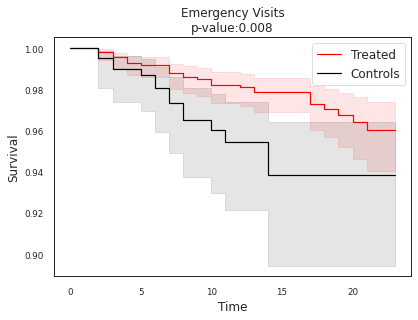

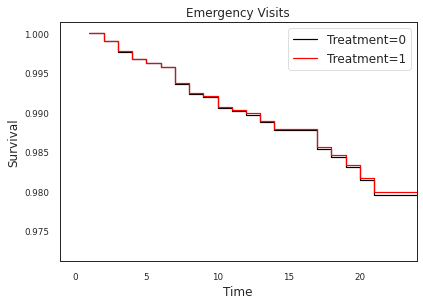

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits         6.99129  0.008191  6.931793

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -3.900           0.898       -4.343    0.000
Gender               0.417           0.339        1.233    0.218
Total Cost           0.251           0.240        1.047    0.295
Tobacco use          0.989           0.346        2.862    0.004
Obesity              0.168           0.317        0.530    0.596
Hypertension         0.290           0.364        0.799    0.424
Hypothyroid          0.113           0.463        0.244    0.807
Disease Count        3.059           1.094        2.796    0.005
Treatment           -0.017           0.369       -0.047    0.963

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.01 s, sys: 438 µs, total: 3.01 s
Wall time: 3.01 s


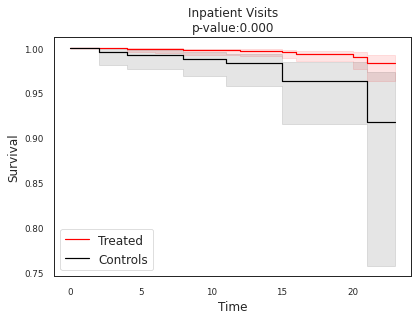

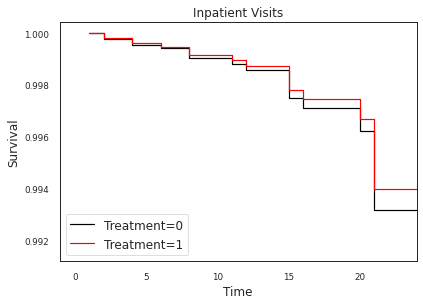

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits       20.620163  0.000006  17.44606

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.906           1.528       -1.247    0.212
Gender               0.577           0.519        1.112    0.266
Total Cost           2.850           1.519        1.876    0.061
Tobacco use          0.350           0.544        0.644    0.520
Obesity              0.031           0.522        0.060    0.952
Hypertension         0.533           0.699        0.763    0.445
Hypothyroid         -0.824           1.079       -0.764    0.445
Disease Count        5.487           1.367        4.014    0.000
Treatment           -0.125           0.564       -0.221    0.825

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.07 s, sys: 10.3 ms, total: 3.08 s
Wall time: 3.08 s


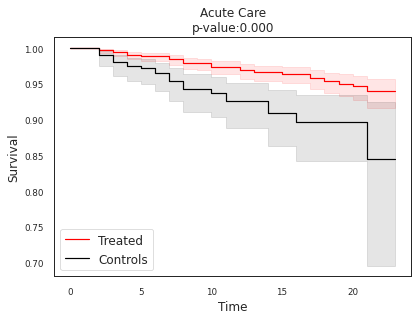

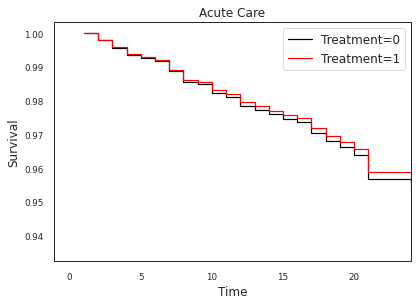

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [28]:
lrsumm

test_statistic         p   -log2(p)
Acute Care       16.674697  0.000044  14.460093

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -3.069           0.694       -4.425    0.000
Gender               0.269           0.260        1.032    0.302
Total Cost           0.254           0.193        1.320    0.187
Tobacco use          0.546           0.282        1.936    0.053
Obesity              0.092           0.241        0.384    0.701
Hypertension         0.235           0.284        0.826    0.409
Hypothyroid         -0.263           0.387       -0.680    0.497
Disease Count        4.390           0.756        5.805    0.000
Treatment           -0.048           0.281       -0.171    0.864

### Load all Log Rank Sums in a matrix

In [30]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [31]:
df2

logRank statistic   p-value  RMST difference
Diabetes                1734.829937  0.000000        20.847970
Emergency Visits          13.014478  0.000309         0.493216
Inpatient Vistis          20.620163  0.000006         0.496294
Acute Care                16.674697  0.000044         1.033979